# How to call text-to-image DIAL applications

From this notebook, you will learn how to call text-to-image applications via [DIAL API chat/completions](https://epam-rail.com/dial_api#/paths/~1openai~1deployments~1%7BDeployment%20Name%7D~1chat~1completions/post) call.


https://github.com/epam/ai-dial/blob/main/dial-cookbook/examples/how_to_call_text_to_image_applications.ipynb


**DIAL application** is a general term, which encompasses model adapters and applications with any custom logic.

DIAL currently supports a few text-to-image model adapters:

* [DALL-E-3](https://github.com/epam/ai-dial-adapter-openai/)
* [Google Imagen](https://github.com/epam/ai-dial-adapter-vertexai/)
* [Stability diffusion](https://github.com/epam/ai-dial-adapter-bedrock/)

These models follow the same pattern of usage: they take the last user message as a prompt for image generation and return the generated image in the response.

For example purposes, we are going to use a sample text-to-image application called `render-text` which prints the user prompt as an image.

The application returns:
1. **completion text** with a Markdown image link to the generated image,
2. **file attachment** which contains either
    * a base64-encoded image or
    * a URL to the image stored in the DIAL storage.

The format of the image attachment is controlled by the user message, which is expected to have the following format: `(base64|url),<text to render>`.

## Setup

**Step 1**: install all the necessary dependencies and import the libraries we are going to use.

In [ ]:
!pip install requests==2.32.3
!pip install openai==1.43.0
!pip install langchain-openai==0.1.23

In [2]:
import requests
import openai
import langchain_openai
from IPython.display import Markdown

**Step 2**: if DIAL Core server is already configured and running, set env vars `DIAL_URL` and `APP_NAME` to point to the DIAL Core server and the text-to-image application (or model) you want to use.

Otherwise, run the [docker-compose file](https://github.com/epam/ai-dial/blob/main/dial-cookbook/docker-compose.yml) in a separate terminal to start the **DIAL Core** server locally along with a sample **render-text** application. The DIAL Core will become available at `http://localhost:8080`:

```sh
docker compose up core render-text
```

**Step 3**: configure `DIAL_URL` and `APP_NAME` env vars. The default values are configured under the assumption that DIAL Core is running locally via the docker-compose file.

In [10]:
import os

dial_url = os.environ.get("DIAL_URL", "http://localhost:8080")
os.environ["DIAL_URL"] = dial_url

app_name = os.environ.get("APP_NAME", "render-text")
os.environ["APP_NAME"] = app_name

**Step 4**: define helpers to display images in the notebook:

In [5]:
import base64

from IPython.display import Image as IPImage
from IPython.display import display

def display_base64_image(image_base64):
    image_binary = base64.b64decode(image_base64)
    display(IPImage(data=image_binary))

## DIAL attachments

The `render-text` application returns an image in its response.
The DIAL API allows to specify a list of attachment files for each message in the DIAL request as well as in the message returned in the DIAL response.

The files attached to the request we call **input attachments**. 
They are saved at the path `messages/{message_idx}/custom_content/attachments/{attachment_idx}`.

And the files attached to the response we call **output attachments**. 
They are saved at the path `message/custom_content/attachments/{attachment_idx}`.

A single attachment *(in our case an image attachment)* may either contain the content of the image encoded in base64:

```json
{
  "type": "image/png",
  "title": "Image",
  "data": "<base64-encoded image data>"
}
```

or reference the attachment content via a URL:

```json
{
  "type": "image/png",
  "title": "Image",
  "url": "<image URL>"
}
```

The image URL is either
1. a publicly accessible URL or
2. a URL to an image uploaded to the DIAL Core server beforehand.

## Downloading file from the DIAL file storage

Let's define a helper method, which downloads an image from the DIAL file storage given a file URL.

If application returns a relative URL, then it resolves it against the DIAL Core URL.
If the URL points to the DIAL Core server, then we need to provide the DIAL Core headers to be able to download the file.

In [6]:
from urllib.parse import urlparse

def is_relative_url(url) -> bool:
    parsed_url = urlparse(url)
    return (
        not parsed_url.scheme
        and not parsed_url.netloc
        and not url.startswith("/")
    )

def download_file_as_base64(dial_url: str, file_url: str, dial_headers: dict[str, str]) -> str:
    if is_relative_url(file_url):
        file_url = f"{dial_url}/v1/{file_url}"

    headers = dial_headers if file_url.startswith(dial_url) else {}

    response = requests.get(file_url, headers=headers)
    response.raise_for_status()
    data = response.content
    return base64.b64encode(data).decode()

Now we demonstrate how to call the application via DIAL API and extract the image from the response.

## Using Curl

* The application deployment is called `app_name`.
* The local DIAL Core server URL is `dial_url`.
* The OpenAI API version we are going to use is `2023-12-01-preview`.

Therefore, the application is accessible via the url:

```
${DIAL_URL}/openai/deployments/${APP_NAME}/chat/completions?api-version=2023-12-01-preview
```

### Using base64-encoded image data

The curl command with a singe message asking for base64-encoded image:

{"choices":[{"index":0,"finish_reason":"stop","message":{"role":"assistant","custom_content":{"attachments":[{"index":0,"type":"image/png","title":"Image","data":"iVBORw0KGgoAAAANSUhEUgAAAMgAAABkCAIAAABM5OhcAAAGHUlEQVR4nO3ZXWhTZxzH8e9psrbaiNham6JFQS2+QDOsbL4N6lYmoiK+i7tQbwrihYoX4o26zgtFtwkrgyobY9NuoAiKgi+1RqlvuImgNxNFC0XxtbMqvrRJdpGDMaenNpX9183+Ppyb8+TJk+ecfGfSzEkkEPnHZfX0BuT9pLDEhMISEwpLTCgsMaGwxITCEhMKS0woLDGhsMSEwhITCktMKCwxobDExL8dluMwbFinp/9NGW5y2DAcx3wz/xcZhfWWO6u72Zlefmf0USgmFJaYMAlr3z6mTKFfP0Ihpk4lGu3e048eZcYMCgvJzqa4mAULuHjRZ9rYsTgON2+mRn79FcchGOTx49RgbS2OQ01NpusnP/cvXaKsjECAFy/8N7l3r3uN+flUVHD2bPeu8f2XSHR9AEOH+j80dKh3kXXrACZPpqaGb75h9GgCAQ4d8l+q48pffQUwciRbt7JnD19+SThMIMAvv3hfev16gJ07UyNVVQSDAAcPpgbnzwdoasp0fSAcprSUadOoqSEW89nkmjXuNdbW8t13TJpEOMzAgWm3ouOd6VVHZpMyDuvYMYCZM2lvd0daWykuZvBg2tp8lvKcnjqF4xCJ8ORJavD2bcJhcnO5cSPtpc+fB1i0KDVSWsoXX5CdzerV7kg8TkEBH37YjfWTVq7sdJOHDwNUVqauMRZj7lzvf6gKK4NJUFJCS4vPUVKSdvtmzQK4ejXt6Rs2ANTX+7xJntM5cwCOHPFu4PvvAdauTRuMxykuprCQeJxEgtu3Aerq+OQTI
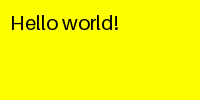

In [11]:
!curl -X POST "${DIAL_URL}/openai/deployments/${APP_NAME}/chat/completions?api-version=2023-12-01-preview" \
  -H "Api-Key:dial_api_key" \
  -H "Content-Type:application/json" \
  -d '{"messages": [{"role": "user", "content": "base64,Hello world!"}]}'

### Using DIAL storage

Now with the DIAL storage, the request is the same, but we are requesting an image URL instead of base64-encoded image data:

{"choices":[{"index":0,"finish_reason":"stop","message":{"role":"assistant","custom_content":{"attachments":[{"index":0,"type":"image/png","title":"Image","url":"files/FSWLtFA648cQNf6WfxHZcFzdABKNsTr7ygwQjYbiDi1n/appdata/render-text/images/picture.png"}]},"content":""}}],"usage":null,"id":"1e6d8fc1-b25b-454e-92fa-52557c03e19f","created":1707310928,"object":"chat.completion"}
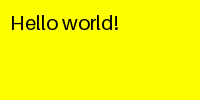

In [12]:
!curl -X POST "${DIAL_URL}/openai/deployments/${APP_NAME}/chat/completions?api-version=2023-12-01-preview" \
  -H "Api-Key:dial_api_key" \
  -H "Content-Type:application/json" \
  -d '{"messages": [{"role": "user", "content": "url,Hello world!"}]}'

## Using Python library Requests


Let's make an HTTP request using the Python `requests` library and then display the generated image.

The arguments are identical to the curl command above.

### Non-streaming mode using base64-encoded image data

Let's call the application in the **non-streaming** mode:


{'choices': [{'index': 0,
   'finish_reason': 'stop',
   'message': {'role': 'assistant',
    'custom_content': {'attachments': [{'index': 0,
       'type': 'image/png',
       'title': 'Image',
       'data': 'iVBORw0KGgoAAAANSUhEUgAAAMgAAABkCAIAAABM5OhcAAAIc0lEQVR4nO2cbWwU5RaAn36v3RVky9JttrQN0KpNWkqtGgG1hKI2WlNRiaixMSEaQyV+/KiRpJRiiEbAimhsFGmVEuOSEI1EEZKqQZFY9YfEWIUo0oiRGrStVNpu5/7YuUxndrszC7x3e9fz5PzYeefMeWdmn85Oduc0RdMQhItOaqJ3QEhORCxBCSKWoAQRS1CCiCUoQcQSlCBiCUoQsQQliFiCEkQsQQkilqAEEUtQgoglKEHEEpQgYglKSHKx2tpoaUn0TvwrSUnuB/2Kijh+nOQ+xqlJkl+xhERhL1ZKCkVFfP015eWkpfHPP/r47t0sXsyll+LxsGQJH39s3TAY1BO8Xqqr+fxziopISbFWtmDJsZ0rFGLrVsrKcLsJBFixgh9/NOofP66/OFczRn7kUf/8Mw0NzJ6Nx0NlJV1d1rR9+7j1Vnw+MjPJy+Puu/nyy7iLJCeaZhOA309JCTffzLZthEJoGk1NAIsWsW0bW7Zw5ZWkpfH++8ZWjz+uJ7S389JLLFyI38/MmaYZgcJC63SFhda9ij3XY48B1NfT2cnatbhczJrFiRNoGsEgPh9AMEgwaJ9vOeqCAioqWLqUjg42bSI/H6Cz08jZsAGguJjnnqOri/Xr8ftJS+Ott+IokqzhSCxg9Wpj5KOPAG67jbExfWRggLw8AgFGR9E09u4FqKkxEkIhli+3quxELNu5LruMadP015rG5s0ATz0VvZptvuWoly3T/
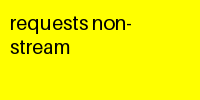

Completion: ''

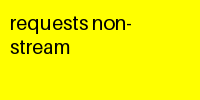

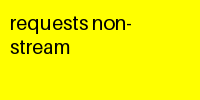

In [13]:
response = requests.post(
    f"{dial_url}/openai/deployments/{app_name}/chat/completions?api-version=2023-12-01-preview",
    headers={"Api-Key": "dial_api_key"},
    json={"messages": [{"role": "user", "content": "base64,requests non-stream"}]},
)
body = response.json()
display(body)
message = body["choices"][0]["message"]
completion = message["content"]
print(f"Completion: {completion!r}")
assert completion.startswith("![Image](data:image/png;base64,"), "Unexpected completion"

image_data = message["custom_content"]["attachments"][0]["data"]
display_base64_image(image_data)

### Non-streaming mode using DIAL storage

Now we ask to return URL to the image in DIAL storage. The only difference is that we need to download the image first and then display it.

{'choices': [{'index': 0,
   'finish_reason': 'stop',
   'message': {'role': 'assistant',
    'custom_content': {'attachments': [{'index': 0,
       'type': 'image/png',
       'title': 'Image',
       'url': 'files/FSWLtFA648cQNf6WfxHZcFzdABKNsTr7ygwQjYbiDi1n/appdata/render-text/images/picture.png'}]},
    'content': ''}}],
 'usage': None,
 'id': '05987e87-3818-41c1-b4fd-c42d6b765926',
 'created': 1707310938,
 'object': 'chat.completion'}
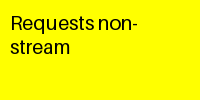

In [14]:
response = requests.post(
    f"{dial_url}/openai/deployments/{app_name}/chat/completions?api-version=2023-12-01-preview",
    headers={"Api-Key": "dial_api_key"},
    json={"messages": [{"role": "user", "content": "url,Requests non-stream"}]},
)
body = response.json()
display(body)
message = body["choices"][0]["message"]
completion = message["content"]
assert completion.startswith("![Image](data:image/png;base64,"), "Unexpected completion"

The application completion contains a Markdown image, which we could display in the notebook:

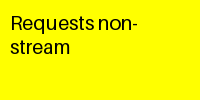

In [15]:
Markdown(completion)

The same image is saved as an image attachment.
We download the image from the DIAL storage first and then display it:

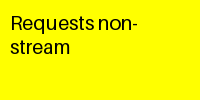

In [16]:
image_url = message["custom_content"]["attachments"][0]["url"]
image_data = download_file_as_base64(dial_url, image_url, {"Api-Key": "dial_api_key"})
display_base64_image(image_data)

From now on, we only demonstrate the use cases with DIAL storage.

### Streaming mode using DIAL storage

When **streaming is enabled**, the chat completion returns a sequence of messages, each containing a chunk of a generated response:

b'data: {"choices":[{"index":0,"finish_reason":null,"delta":{"role":"assistant"}}],"usage":null,"id":"9cae589e-238f-405d-8747-e1f5544ad6dc","created":1707310961,"object":"chat.completion.chunk"}'
b''
b'data: {"choices":[{"index":0,"finish_reason":null,"delta":{"custom_content":{"attachments":[{"index":0,"type":"image/png","title":"Image","url":"files/FSWLtFA648cQNf6WfxHZcFzdABKNsTr7ygwQjYbiDi1n/appdata/render-text/images/picture.png"}]}}}],"usage":null,"id":"9cae589e-238f-405d-8747-e1f5544ad6dc","created":1707310961,"object":"chat.completion.chunk"}'
b''
b'data: {"choices":[{"index":0,"finish_reason":null,"delta":{"content":""}}],"usage":null,"id":"9cae589e-238f-405d-8747-e1f5544ad6dc","created":1707310961,"object":"chat.completion.chunk"}'
b''
b'data: {"choices":[{"index":0,"finish_reason":"stop","delta":{}}],"usage":null,"id":"9cae589e-238f-405d-8747-e1f5544ad6dc","created":1707310961,"object":"chat.completion.chunk"}'
b''
b'data: [DONE]'
b''

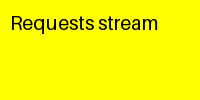

In [17]:
response = requests.post(
    f"{dial_url}/openai/deployments/{app_name}/chat/completions?api-version=2023-12-01-preview",
    headers={"Api-Key": "dial_api_key"},
    json={"messages": [{"role": "user", "content": "url,Requests stream"}], "stream": True},
)
for chunk in response.iter_lines():
    print(chunk)

## Using OpenAI Python SDK

The DIAL deployment could be called using [OpenAI Python SDK](https://pypi.org/project/openai/) as well.


In [18]:
openai_client = openai.AzureOpenAI(
    azure_endpoint=dial_url,
    azure_deployment=app_name,
    api_key="dial_api_key",
    api_version="2023-12-01-preview",
)

Let's call the application in the **non-streaming** mode:

ChatCompletion(id='a029ad1c-ad4d-40e3-b293-6252f73dc079', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='', role='assistant', function_call=None, tool_calls=None, custom_content={'attachments': [{'index': 0, 'type': 'image/png', 'title': 'Image', 'url': 'files/FSWLtFA648cQNf6WfxHZcFzdABKNsTr7ygwQjYbiDi1n/appdata/render-text/images/picture.png'}]}))], created=1707310972, model=None, object='chat.completion', system_fingerprint=None, usage=None)

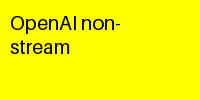

In [19]:

chat_completion = openai_client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "url,OpenAI non-stream",
        }
    ],
    model=app_name,
)
print(chat_completion)
message = chat_completion.choices[0].message
completion = message.content
assert completion.startswith("![Image](data:image/png;base64,"), "Unexpected completion"

The application completion contains a Markdown image, which we could display in the notebook:

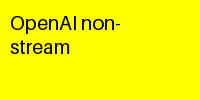

In [20]:
Markdown(completion)

The same image is saved as an image attachment.
We download the image from the DIAL storage first and then display it:

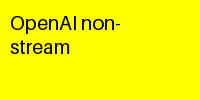

In [21]:
image_url = message.custom_content["attachments"][0]["url"]
image_data = download_file_as_base64(dial_url, image_url, {"Api-Key": "dial_api_key"})
display_base64_image(image_data)

Let's call the application in the **streaming** mode:

ChatCompletionChunk(id='6b6dd28f-4074-4dfe-bf31-9f51540bdd70', choices=[Choice(delta=ChoiceDelta(content=None, function_call=None, role='assistant', tool_calls=None), finish_reason=None, index=0, logprobs=None)], created=1707310983, model=None, object='chat.completion.chunk', system_fingerprint=None, usage=None)
ChatCompletionChunk(id='6b6dd28f-4074-4dfe-bf31-9f51540bdd70', choices=[Choice(delta=ChoiceDelta(content=None, function_call=None, role=None, tool_calls=None, custom_content={'attachments': [{'index': 0, 'type': 'image/png', 'title': 'Image', 'url': 'files/FSWLtFA648cQNf6WfxHZcFzdABKNsTr7ygwQjYbiDi1n/appdata/render-text/images/picture.png'}]}), finish_reason=None, index=0, logprobs=None)], created=1707310983, model=None, object='chat.completion.chunk', system_fingerprint=None, usage=None)
ChatCompletionChunk(id='6b6dd28f-4074-4dfe-bf31-9f51540bdd70', choices=[Choice(delta=ChoiceDelta(content='', function_call=None, role=None, tool_calls=None), finish_reason=None, index=0, logpr
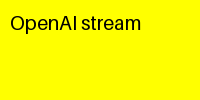

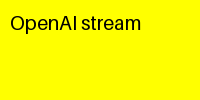

In [22]:
chat_completion = openai_client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "url,OpenAI stream",
        }
    ],
    stream=True,
    model=app_name,
)
completion = ""
for chunk in chat_completion:
    print(chunk)
    content = chunk.choices[0].delta.content
    if content:
        completion += content
assert completion.startswith("![Image](data:image/png;base64,"), "Unexpected completion"
Markdown(completion)

## Using LangChain

The [LangChain](https://pypi.org/project/langchain-openai/) library **is not suitable** as a client of text-to-image applications, since `langchain-openai` ignores additional fields attached to the response message.

Meaning that the response won't contain any image attachments.
It's still possible to use the application completion if an application returns image that way:

In [23]:
from langchain_core.messages import HumanMessage

llm = langchain_openai.AzureChatOpenAI(
    azure_endpoint=dial_url,
    azure_deployment=app_name,
    api_key="dial_api_key",
    api_version="2023-12-01-preview",
)

Let's call the application in the **non-streaming** mode:

generations=[[ChatGeneration(text='', generation_info={'finish_reason': 'stop', 'logprobs': None}, message=AIMessage(content=''))]] llm_output={'token_usage': {}, 'model_name': 'gpt-3.5-turbo'} run=[RunInfo(run_id=UUID('d533d005-95f2-4c24-a45d-be90e7f67e58'))]
Completion: ''

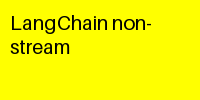
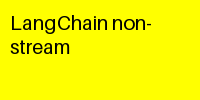
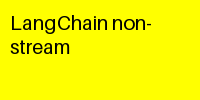

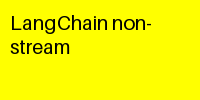

In [24]:
output = llm.generate(messages=[[HumanMessage(content="url,LangChain non-stream")]])
print(output)
completion = output.generations[0][0].text
print(f"Completion: {completion!r}")
assert completion.startswith("![Image](data:image/png;base64,"), "Unexpected completion"
Markdown(completion)

Let's call the application in the **streaming** mode:

{'content': '', 'additional_kwargs': {}, 'type': 'AIMessageChunk', 'example': False}
{'content': '', 'additional_kwargs': {}, 'type': 'AIMessageChunk', 'example': False}
{'content': '', 'additional_kwargs': {}, 'type': 'AIMessageChunk', 'example': False}
{'content': '', 'additional_kwargs': {}, 'type': 'AIMessageChunk', 'example': False}

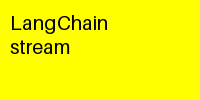

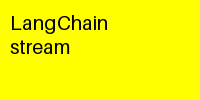

In [25]:
output = llm.stream(input=[HumanMessage(content="url,LangChain stream")])
completion = ""
for chunk in output:
    print(chunk.dict())
    completion += chunk.content
assert completion.startswith("![Image](data:image/png;base64,"), "Unexpected completion"
Markdown(completion)